In [30]:
import os, sys
import numpy as np
import pandas as pd
import re
from sklearn.decomposition import PCA

def read_samples(samplefile):
    if os.path.exists(samplefile):
        with open(samplefile, 'r') as samfile:
            sample = 0
            samplenames = list()
            next(samfile)
            next(samfile)
            for line in samfile:
                if re.search('^#', line):
                    continue
                sample += 1
                samplenames.append(line.strip().split()[0])
        nsample = sample
        samplenames = samplenames
        return samplenames, nsample

def knn_correction_noDS(expr, K, pc=30):
    print(f"ncomp: {pc}")
    pca = PCA(n_components=pc )
#     print("Original dimension: {:d} x {:d}".format(expr.shape[0], expr.shape[1]))
    pca.fit(expr) # requires N x G
    expr_pca = pca.transform(expr)
#     print("Reduced dimension: {:d} x {:d}".format(expr_pca.shape[0], expr_pca.shape[1]))

    def gene_distance(a, b):
        return np.linalg.norm(a - b)

    nsample = expr.shape[0]
    distance_matrix = np.zeros((nsample, nsample))
    for i in range(nsample):
        for j in range(i+1, nsample):
            dist = gene_distance(expr_pca[i,:], expr_pca[j,:])
            distance_matrix[i, j] = dist
            distance_matrix[j, i] = dist

    kneighbor = K
    gx_knn = np.zeros_like(expr)
    neighbor_list = list()

    for i in range(nsample):
        neighbors = np.argsort(distance_matrix[i, :])[:kneighbor + 1][1:]
        gx_knn[i, :] = expr[i, :] - np.mean(expr[neighbors, :], axis = 0)
        # noisy_neighbors = np.random.choice(neighbors, size = int(2 * kneighbor / 3), replace = False)
        # noisy_neighbors = np.random.choice(neighbors, size = kneighbor, replace = True )
        noisy_neighbors = neighbors
        neighbor_list.append(neighbors)

    return gx_knn
    
def knn_correction(expr, dosage, K, f=1):
    print(expr.shape, dosage.shape)
    assert (gx.shape[0] == dosage.shape[1])
    pca = PCA(n_components=int(f * min(expr.shape[0], expr.shape[1]) ))
#     print("Original dimension: {:d} x {:d}".format(expr.shape[0], expr.shape[1]))
    pca.fit(expr) # requires N x G
    expr_pca = pca.transform(expr)
#     print("Reduced dimension: {:d} x {:d}".format(expr_pca.shape[0], expr_pca.shape[1]))

    def gene_distance(a, b):
        return np.linalg.norm(a - b)

    nsample = expr.shape[0]
    distance_matrix = np.zeros((nsample, nsample))
    for i in range(nsample):
        for j in range(i+1, nsample):
            dist = gene_distance(expr_pca[i,:], expr_pca[j,:])
            distance_matrix[i, j] = dist
            distance_matrix[j, i] = dist

    kneighbor = K
    gx_knn = np.zeros_like(expr)
    gt_knn = np.zeros_like(dosage)
    neighbor_list = list()

    for i in range(nsample):
        neighbors = np.argsort(distance_matrix[i, :])[:kneighbor + 1][1:]
        gx_knn[i, :] = expr[i, :] - np.mean(expr[neighbors, :], axis = 0)
        # noisy_neighbors = np.random.choice(neighbors, size = int(2 * kneighbor / 3), replace = False)
        # noisy_neighbors = np.random.choice(neighbors, size = kneighbor, replace = True )
        noisy_neighbors = neighbors
        gt_knn[:, i] = dosage[:, i] - np.mean(dosage[:, noisy_neighbors], axis = 1)
        neighbor_list.append(neighbors)

    return gx_knn, gt_knn

In [3]:
# Load real expression
tissue="as"
# - No corrections
df = pd.read_csv("/cbscratch/franco/trans-eqtl/new_preprocess_feb2020_freeze/gtex_v8/expression/tpms/{:s}_tpms_qcfilter.txt.protein_coding_lncRNA_filtered".format(tissue), header=0, index_col=0, sep="\t")

# pub data reminder
# df = pd.read_csv("/cbscratch/franco/trans-eqtl/new_preprocess_nov2019_pub/gtex_v8/expression/tpms/{:s}_tpms_qcfilter.txt.protein_coding_lncRNA_filtered".format(tissue), header=0, index_col=0, sep="\t")
ngene, nsample = df.shape
gx_donors = list(df.columns)
gx = df.values
gene_names = list(df.index)
print(gx.shape)
print("Matrix rank:", np.linalg.matrix_rank(gx))

(15673, 581)
Matrix rank: 580


In [8]:
def select_samples(user_samples, expr_samples):
    common_samples = [x for x in expr_samples if x in user_samples]
    samples_idx = [expr_samples.index(x) for x in common_samples]
    return samples_idx

samplefile_eur = "/cbscratch/franco/datasets/gtex_v8/genotypes/gtex_v8_eur.sample"
samplefile_eur_noadm = "/cbscratch/franco/datasets/gtex_v8/genotypes/gtex_v8_eur_noADM.sample"
samplefile_all = "/cbscratch/franco/datasets/gtex_v8/genotypes/gtex_v8.sample"

samplenames, nsample = read_samples(samplefile_eur)
exprmask_eur = select_samples(samplenames, gx_donors)

samplenames, nsample = read_samples(samplefile_eur_noadm)
exprmask_eur_noadm = select_samples(samplenames, gx_donors)

samplenames, nsample = read_samples(samplefile_all)
exprmask_all = select_samples(samplenames, gx_donors)

expr = gx[:, exprmask_all]
print(expr.shape)
expr_eur = gx[:, exprmask_eur]
print(expr_eur.shape)
expr_eur_noadm = gx[:, exprmask_eur_noadm]
print(expr_eur_noadm.shape)

(15673, 581)
(15673, 415)
(15673, 405)


[8.42116815e+01 8.36294771e+01 8.32323660e+01 8.30317211e+01
 8.26456798e+01 8.23039617e+01 8.18006055e+01 8.12182141e+01
 8.03127971e+01 1.70541100e-12]
[90.62299792 90.47406704 89.54088167 89.40163661 88.82876789 87.9948627
 87.73281776 86.97449058 86.01666468 83.1549929 ]
[90.69958799 90.66950481 89.70151162 89.47460756 89.04505487 88.1435419
 87.98371186 87.08704387 86.11106459 83.36271533]


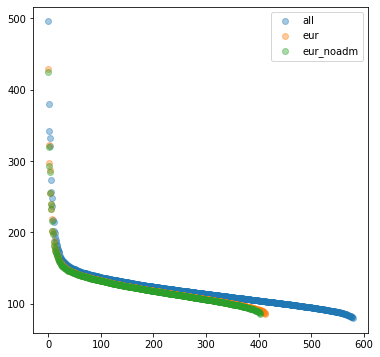

In [12]:
import matplotlib.pyplot as plt

expressions = dict()
expressions["all"] = expr
expressions["eur"] = expr_eur
expressions["eur_noadm"] = expr_eur_noadm


fig = plt.figure(figsize=(6,6))
ax1 = fig.add_subplot(111)
for k in expressions:
    Yt = expressions[k].T
    U, S, Vt = np.linalg.svd(Yt, full_matrices=False)
    S2 = np.square(S)
    print(S[-10:])
    ax1.scatter(np.arange(len(S)-1), S[:-1], label = k, alpha=0.4)
    
ax1.legend()
plt.show()

ncomp: 581
ncomp: 415
ncomp: 405
ncomp: 30
ncomp: 30
ncomp: 30


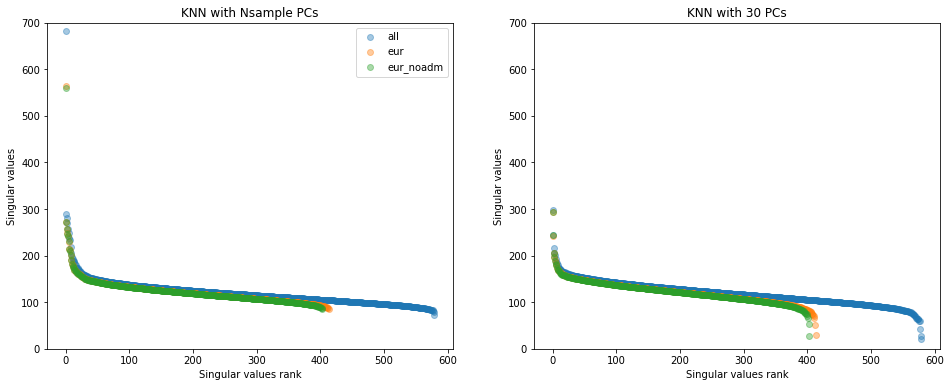

In [37]:
expressions = dict()
expressions["all"] = knn_correction_noDS(expr.T, K=30, pc=expr.shape[1])
expressions["eur"] = knn_correction_noDS(expr_eur.T, K=30, pc=expr_eur.shape[1])
expressions["eur_noadm"] = knn_correction_noDS(expr_eur_noadm.T, K=30, pc=expr_eur_noadm.shape[1])


fig = plt.figure(figsize=(16,6))
ax1 = fig.add_subplot(121)
for k in expressions:
    Yt = expressions[k].T
    U, S, Vt = np.linalg.svd(Yt, full_matrices=False)
    S2 = np.square(S)
    ax1.scatter(np.arange(len(S)-1), S[:-1], label = k, alpha=0.4)

ax1.legend()

expressions = dict()
expressions["all"] = knn_correction_noDS(expr.T, K=30, pc=30)
expressions["eur"] = knn_correction_noDS(expr_eur.T, K=30, pc=30)
expressions["eur_noadm"] = knn_correction_noDS(expr_eur_noadm.T, K=30, pc=30)

ax2 = fig.add_subplot(122)
for k in expressions:
    Yt = expressions[k].T
    U, S, Vt = np.linalg.svd(Yt, full_matrices=False)
    S2 = np.square(S)
    ax2.scatter(np.arange(len(S)-1), S[:-1], label = k, alpha=0.4)
    
ax1.set_title("KNN with Nsample PCs")
ax2.set_title("KNN with 30 PCs")
ax1.set_ylabel("Singular values")
ax1.set_xlabel("Singular values rank")
ax2.set_ylabel("Singular values")
ax2.set_xlabel("Singular values rank")

ax1.set_ylim(0,700)
ax2.set_ylim(0,700)

plt.show()